# Homework 2: ImageGPT

In [1]:
REPO_NAME = "2022-2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Cloning into '2022-2023-DGM-MIPT-course'...
remote: Enumerating objects: 470, done.
remote: Counting objects: 100% (204/204), done.
remote: Compressing objects: 100% (163/163), done.
remote: Total 470 (delta 78), reused 139 (delta 39), pack-reused 266
Receiving objects: 100% (470/470), 195.06 MiB | 37.67 MiB/s, done.
Resolving deltas: 100% (82/82), done.
Checking out files: 100% (288/288), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./2022-2023-DGM-MIPT-course/homeworks
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dgm-utils: filename=dgm_utils-0.1.0-p

In [2]:
from dgm_utils import train_model, plot_training_curves
from dgm_utils import show_samples, visualize_images, load_pickle

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

USE_CUDA = torch.cuda.is_available()

## Task: ImageGPT on MNIST

[ImageGPT](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) model uses Transformers on images.

Here you have to train this model on MNIST images. See paper for details.

Download the data from [here](https://drive.google.com/file/d/1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw/view?usp=sharing) (you could use the cell below).

In [4]:
!gdown --id 1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1hExV0C8wQWsrA4HfRTq9y9rMo7Pjd9Gw
To: /content/mnist.pkl
100% 188M/188M [00:00<00:00, 227MB/s]


torch.Size([54000, 1, 28, 28])


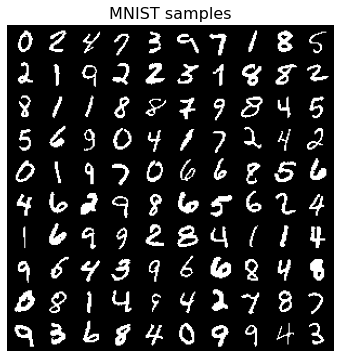

In [106]:
# train_data, test_data = load_pickle('./content/mnist.pkl', flatten=False, binarize=True)
from torchvision import datasets
import torchvision.transforms as T
from torch.utils.data import random_split

target_transform = T.Compose([T.ToTensor(),
                              T.Lambda(lambda x: torch.round(x).long())
                              ])
train_data = datasets.MNIST(
        '/content/mnist', train=True, download=True, transform=target_transform
    )
test_data = datasets.MNIST(
        '/content/mnist', train=True, download=True, transform=target_transform
    )
train_size = int(0.9 * len(train_data))

# reproducable split
# NOTE: splitting is done twice as datasets have different transforms attributes
train_data, _ = random_split(
    train_data,
    [train_size, len(train_data) - train_size],
    generator=torch.Generator().manual_seed(0),
)
_, test_data = random_split(
    test_data,
    [train_size, len(test_data) - train_size],
    generator=torch.Generator().manual_seed(0),
)

# train_data, test_data = load_pickle('./mnist.pkl', flatten=False, binarize=True)
# train_data, test_data = load_pickle('/content/mnist.pkl', flatten=False, binarize=True)
# # train_data, test_data = load_pickle('./mnist.pkl', flatten=False, binarize=True)
# print(train_data[0][0])
imgs = torch.cat([img*255 for img, _ in train_data])[:, None, :, :]

print(imgs.shape)
visualize_images(imgs, 'MNIST samples')

The transformer decoder takes an input sequence $x_1, \dots, x_n$
of discrete tokens and produces a d-dimensional embedding
for each position. The decoder is realized as a stack of
$L$ blocks, the $l$-th of which produces an intermediate embedding $h^l_1, \dots , h^l_n$
also of dimension $d$. Authors use GPT, so, let's build it. Transformers blocks are the basic building block of GPT2 model:<br>
$n^l= layer\_norm (h^l)$ <br> 
$a^l= h^l + multihead\_attention(n^l)$ <br> 
$h^{l+1}= a^l + mlp(layer\_norm (a^l))$ <br> 
To ensure proper conditioning when
training the Auto-regressive objective, we apply the standard upper
triangular mask to the $n×n$ matrix of attention logits.

In [107]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(Block, self).__init__()
        self.ln_1 = nn.LayerNorm(embed_dim)
        self.ln_2 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.GELU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        attn_mask = torch.full(
            (len(x), len(x)), -float("Inf"), device=x.device, dtype=x.dtype
        )
        # Masking attenton logits to ensure autoregressive property
        attn_mask = torch.triu(attn_mask, diagonal=1)

        x = self.ln_1(x)
        a, _ = self.attn(x, x, x, attn_mask=attn_mask, need_weights=False)
        x = x + a
        m = self.mlp(self.ln_2(x))
        x = x + m
        return x


def test_masked_block():
    # layer = Block('A', 2, 2)
    # # assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    # layer = Block('B', 2, 2)
    # # assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))
    pass


# test_masked_conv2d()

Now we are ready to construct the main GPT2 model.

In [108]:
class GPT2(nn.Module):
    def __init__(
        self, embed_dim, num_heads, num_layers, num_positions, num_vocab, num_classes
    ):
        super(GPT2, self).__init__()

        self.embed_dim = embed_dim

        # start of sequence token
        self.sos = torch.nn.Parameter(torch.zeros(embed_dim))
        nn.init.normal_(self.sos)

        self.token_embeddings = nn.Embedding(num_vocab, embed_dim)
        self.position_embeddings = nn.Embedding(num_positions, embed_dim)

        self.layers = nn.ModuleList()
        for _ in range(num_layers):
            self.layers.append(Block(embed_dim, num_heads))

        self.ln_f = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_vocab, bias=False)
        self.clf_head = nn.Linear(embed_dim, num_classes)

    def forward(self, x, classify=False):
        """
        Expect input as shape [sequence len, batch]
        If classify, return classification logits
        """
        length, batch = x.shape
        h = self.token_embeddings(x.long())

        # prepend sos token
        sos = torch.ones(1, batch, self.embed_dim, device=x.device) * self.sos
        h = torch.cat([sos, h[:-1, :, :]], axis=0)

        # add positional embeddings
        positions = torch.arange(length, device=x.device).unsqueeze(-1)
        h = h + self.position_embeddings(positions).expand_as(h)

        # transformer
        for layer in self.layers:
            h = layer(h)

        h = self.ln_f(h)

        logits = self.head(h)

        if not classify:
            # return logits
            return logits

        h = torch.mean(h, dim=0)  # average pool over sequence
        # return classification logits and generative logits
        return self.clf_head(h), logits

Now let's use it to construct ImageGPT

In [109]:
def _to_sequence(x):
    """shape batch of images for input into GPT2 model"""
    x = x.view(x.shape[0], -1)  # flatten images into sequences
    x = x.transpose(0, 1).contiguous()  # to shape [seq len, batch]
    return x

In [110]:

class ImageGPT(nn.Module):
    def __init__(
        self,
        embed_dim=16,
        num_heads=2,
        num_layers=8,
        num_pixels=28,
        num_vocab=256,
        num_classes=10,
        **kwargs,
    ):
        super().__init__()
        self.gpt = GPT2(
            embed_dim=embed_dim,
            num_heads=num_heads,
            num_layers=num_layers,
            num_positions=num_pixels * num_pixels,
            num_vocab=num_vocab,
            num_classes=num_classes,
        ).cuda()
        self.criterion = nn.CrossEntropyLoss()


    def forward(self, x):
        return self.gpt(x)

    def loss(self, batch, classify):
        x, y = batch
        x = _to_sequence(x).cuda()

        if classify:
            clf_logits, logits = self.gpt(x, classify=True)
            clf_loss = self.criterion(clf_logits, y)
            gen_loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))
            # joint loss for classification
            loss = clf_loss + gen_loss
        else:
            logits = self.gpt(x)
            loss = self.criterion(logits.view(-1, logits.size(-1)), x.view(-1))

        return {"total_loss": loss}

    def sample(self, n):
        # read carefully the sampling process
        samples = torch.zeros(784, n).cuda()
        with torch.no_grad():
            for r in range(784):
                logits = self(samples)
                print(logits.shape)
                probs = F.softmax(logits, dim=1).squeeze(-1)
                samples[r, :] = torch.multinomial(probs, num_samples=1).squeeze(-1)
        return samples.cpu().numpy()  



In [111]:
torch.cuda.empty_cache()
del model


In [112]:
from collections import defaultdict
from tqdm.notebook import tqdm

import torch
from torch import optim


def train_epoch(model, classify, train_loader, optimizer, use_cuda, loss_key='total'):
    model.train()

    stats = defaultdict(list)
    for x, y in train_loader:
        if use_cuda:
            x = x.cuda()
            y = y.cuda()
        losses = model.loss((x, y), classify)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model, classify, data_loader, use_cuda):
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x, y in data_loader:
            if use_cuda:
                x = x.cuda()
                y = y.cuda()
            losses = model.loss((x,y), classify)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model,
    train_loader,
    test_loader,
    epochs,
    lr,
    classify,
    use_tqdm=False,
    use_cuda=False,
    loss_key='total_loss',
):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, classify, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, classify, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

In [113]:
# ====
EPOCHS = 4            # > 5
BATCH_SIZE = 128         # any adequate value
LR = 1e-2                 # < 1e-2
N_LAYERS = 3        # < 10
# ====

model = ImageGPT(num_layers=N_LAYERS)

loss = model.loss((torch.zeros(2, 28, 28, dtype=int), 0), False)
assert isinstance(loss, dict)
assert 'total_loss' in loss

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, num_workers=8)
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader,
    classify=False,
    epochs=EPOCHS, 
    lr=LR, 
    use_cuda=True,
    use_tqdm=True
)
train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader,
    classify=True,
    epochs=EPOCHS, 
    lr=LR, 
    use_cuda=True,
    use_tqdm=True
)

# assert test_losses['total_loss'][-1] < 0.10

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Even if the test loss is bigger than the value in assert, try to visualize train/test curves, it could find you to find the bug.

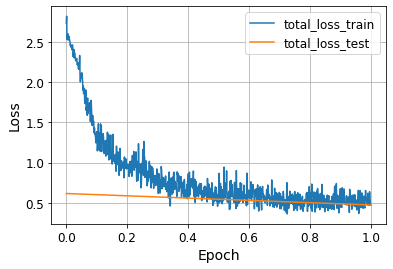

{'total_loss': [2.730224132537842, 2.8179190158843994, 2.530294418334961, 2.543464183807373, 2.601712703704834, 2.5218865871429443, 2.563995838165283, 2.5351130962371826, 2.567084312438965, 2.5182223320007324, 2.511098623275757, 2.453874349594116, 2.467296838760376, 2.432969570159912, 2.4486122131347656, 2.4497623443603516, 2.399688720703125, 2.4619333744049072, 2.4288833141326904, 2.316025972366333, 2.3676843643188477, 2.404874324798584, 2.300973415374756, 2.361729145050049, 2.317181348800659, 2.30295729637146, 2.263261079788208, 2.288217782974243, 2.284630060195923, 2.294029951095581, 2.221869945526123, 2.211132287979126, 2.24293851852417, 2.193941593170166, 2.1596438884735107, 2.238861560821533, 2.1762185096740723, 2.3305444717407227, 2.1009020805358887, 2.0024776458740234, 2.074162483215332, 2.098198413848877, 2.052499532699585, 2.115570545196533, 2.0899620056152344, 2.022207021713257, 1.900058627128601, 1.9498652219772339, 1.8559612035751343, 1.8868632316589355, 1.9215450286865234

In [114]:
plot_training_curves(train_losses, test_losses)
print(train_losses)

Now we sample the new images from the model. You have to emphasize that the sampling from the autoregressive model is slow, because it is a sequential process.

In [115]:
img, _ = test_data[0]
h, w = img.shape[-2:]

seq = img.reshape(-1) 

# first half of image is context
context = seq[: int(len(seq) / 2)]
context_img = np.pad(context, (0, int(len(seq) / 2))).reshape(h, w)
context = context.cuda()
# predict second half of image
samples = model.sample(25).cpu().numpy().transpose()

# samples = model.sample(1, 784, num_samples=25)
samples.reshape(-1, h, w).shape
show_samples(samples.reshape(-1, 1, h, w), title='MNIST samples', nrow=5)

torch.Size([784, 25, 256])


RuntimeError: ignored

### Image autocompletion

The last feature of autoregressive model that we try is auto-completing an image. As autoregressive models predict pixels one by one, we can set the first pixels to predefined values and check how the model completes the image. 
We redefine the sample method in out ImageGPT class to allow it to take init of the sample.

In [ ]:
class ImageGPTAutoComplete(ImageGPT):
    def sample(self, context, length, num_samples=1, temperature=1.0):
        output = context.unsqueeze(-1).repeat_interleave(
            num_samples, dim=-1
        )  # add batch so shape [seq len, batch]
        print(output.shape)
        pad = torch.zeros(1, num_samples, dtype=torch.long).cuda()  # to pad prev output
        print(pad.shape)
        samples = torch.zeros(num_samples, length, 1, dtype=torch.long).cuda()  # to pad prev output
        # print()
        with torch.no_grad():
            for _ in tqdm(range(length), leave=False):
                logits = self(torch.cat((output, pad), dim=0))
                logits = logits[-1, :, :] / temperature
                probs = F.softmax(logits, dim=-1)
                pred = torch.multinomial(probs, num_samples=1).transpose(1, 0)
                output = torch.cat((output, pred), dim=0)
        return output

You have to repeat the model training.

In [ ]:
model = ImageGPTAutoComplete(
    num_layers=N_LAYERS, 
)

train_losses, test_losses = train_model(
    model, 
    train_loader, 
    test_loader, 
    epochs=EPOCHS, 
    lr=LR, 
    use_tqdm=True, 
    use_cuda=True
)

assert test_losses['total_loss'][-1] < 0.10

We randomly take images from the training set, mask the lower half of the image (set -1's), and let the model autocomplete it. We do this several times for each image to see the diversity of samples.

In [ ]:
def autocomplete_image(batch, model, n_samples):
    img, _ = batch
    h, w = img.shape[-2:]

    seq = img.reshape(-1) 

    # first half of image is context
    context = seq[: int(len(seq) / 2)]
    context_img = np.pad(context, (0, int(len(seq) / 2))).reshape(h, w)
    context = context.cuda()
    # predict second half of image
    samples = model.sample(context, int(len(seq) / 2), num_samples=n_samples).cpu().numpy().transpose().reshape(-1, h, w)
    show_samples(samples.reshape(-1, 1, h, w), title='MNIST samples', nrow=4)


for i in range(1, 4):
    autocomplete_image(train_data[i], model, n_samples=4)

